In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("WGCNA")
BiocManager::install("DESeq2")
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'WGCNA'

also installing the dependencies ‘zlibbioc’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘checkmate’, ‘plogr’, ‘png’, ‘Biostrings’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘iterators’, ‘BiocGenerics’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘S4Vectors’, ‘KEGGREST’, ‘dynamicTreeCut’, ‘fastcluster’, ‘matrixStats’, ‘Hmisc’, ‘impute’, ‘foreach’, ‘doParallel’, ‘preprocessCore’, ‘GO.db’, ‘AnnotationDbi’


Old packages: 'cluster', 'shiny'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositor

In [3]:
library(WGCNA)
options(stringsAsFactors = FALSE)
library(dplyr)
library(tidyr)
library(DESeq2)
library(tidyverse)
library(reshape2)
allowWGCNAThreads()

Allowing multi-threading with up to 2 threads.


In [4]:
#devtools::install_github("ropenscilabs/umapr")
#install.packages("gridExtra")
install.packages("ggrepel")
library(ggplot2)
library(gridExtra)
suppressPackageStartupMessages(library(DESeq2))
library(ggrepel)  # For better label placement

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




#clusters

In [5]:
df_raw_t1<- read.csv("/content/df_raw_T1.csv")

In [106]:
new_data <- df_raw_t1[, c("X", "cluster")]

In [107]:
filtered_data <- df_raw_t1 %>% select(-cluster)

In [108]:
transposed_data <- t(filtered_data)

# Setting the first row as column names
colnames(transposed_data) <- transposed_data[1,]
transposed_data <- transposed_data[-1,]

# Convert row names to a proper column if necessary
transposed_data <- as.data.frame(transposed_data)
transposed_data <- transposed_data %>% tibble::rownames_to_column(var = "geneID")
transposed_data[,-1] <- sapply(transposed_data[,-1], as.integer)

In [109]:
# Sum counts across all samples for each gene
gene_totals <- rowSums(transposed_data[, -1])

# Filter out genes with total counts less than 10
filtered_transposed_data <- transposed_data[gene_totals > 10, ]

# Prepare DESeq2 dataset using the filtered data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(filtered_transposed_data[, -1]),
                              colData = new_data,
                              design = ~ cluster)

# Proceed with DESeq2 normalization and analysis
dds <- estimateSizeFactors(dds)
dds <- estimateDispersionsGeneEst(dds)
dispersions(dds) <- mcols(dds)$dispGeneEst
dds <- nbinomWaldTest(dds)

# Extract normalized counts
normalized_counts <- counts(dds, normalized = TRUE)

# Add geneID back to normalized counts
rownames(normalized_counts) <- filtered_transposed_data$geneID

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



In [110]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("genefilter")
# filter out low variance genes
library(genefilter)
high_var_genes <- rowVars(normalized_counts) > quantile(rowVars(normalized_counts), 0.75)
filtered_data <- normalized_counts[high_var_genes, ]

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'genefilter'”
Old packages: 'cluster', 'shiny'



In [111]:
datExpr <- t(filtered_data)


pickSoftThreshold: will use block size 4418.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4418 of 4418
   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k.  max.k.
1      1    0.321 -2.67          0.850 691.0000  6.64e+02 1190.00
2      2    0.791 -2.58          0.946 171.0000  1.53e+02  480.00
3      3    0.932 -2.41          0.986  55.4000  4.42e+01  244.00
4      4    0.966 -2.19          0.992  21.7000  1.48e+01  144.00
5      5    0.976 -2.02          0.997   9.8600  5.54e+00   93.60
6      6    0.981 -1.86          0.997   5.0600  2.26e+00   65.50
7      7    0.980 -1.77          0.998   2.8600  9.79e-01   49.20
8      8    0.975 -1.68          0.993   1.7400  4.52e-01   38.30
9      9    0.967 -1.63          0.989   1.1300  2.15e-01   30.70
10    10    0.953 -1.59          0.981   0.7690  1.07e-01   25.10
11    12    0.960 -1.48          0.988   0.4000  2.91e-02   17.60
12    14    0.954 -1.44          0.985   0.2330  8.54

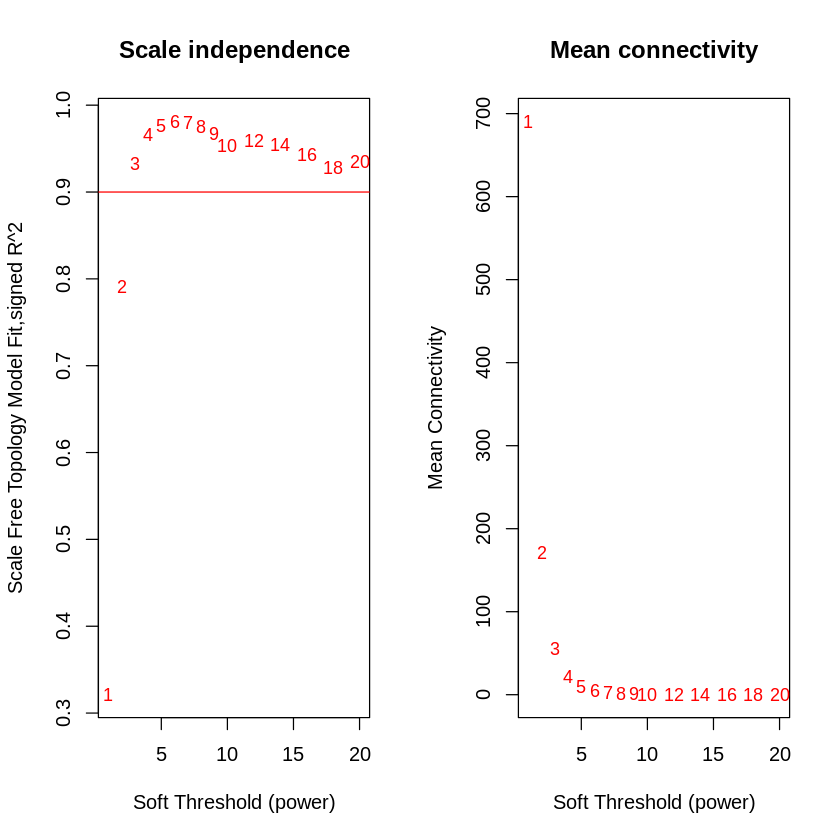

In [112]:
powers <- c(c(1:10), seq(from = 12, to = 20, by = 2))

# Network topology analysis
sft <- pickSoftThreshold(datExpr,
                         powerVector = powers,
                         verbose = 5,
                         networkType = "unsigned")

# Plot the results to help choose the soft threshold power
par(mfrow = c(1,2))
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.90,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")


In [113]:
softPower <- min(powers[sft$fitIndices[, "SFT.R.sq"] >= 0.9])
# Build adjacency and TOM
adjacency <- adjacency(datExpr, power = softPower)
TOM <- TOMsimilarity(adjacency)
dissTOM <- 1 - TOM

# Hierarchical clustering of genes
geneTree <- hclust(as.dist(dissTOM), method = "average")

# Detect modules using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM,
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = 30)
moduleColors <- labels2colors(dynamicMods)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.988  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [114]:
gene_module_df <- data.frame(
  GeneID = colnames(datExpr),
  Module = moduleColors
)

write.csv(gene_module_df, file = "T1_gene_module_assignments.csv", row.names = FALSE)

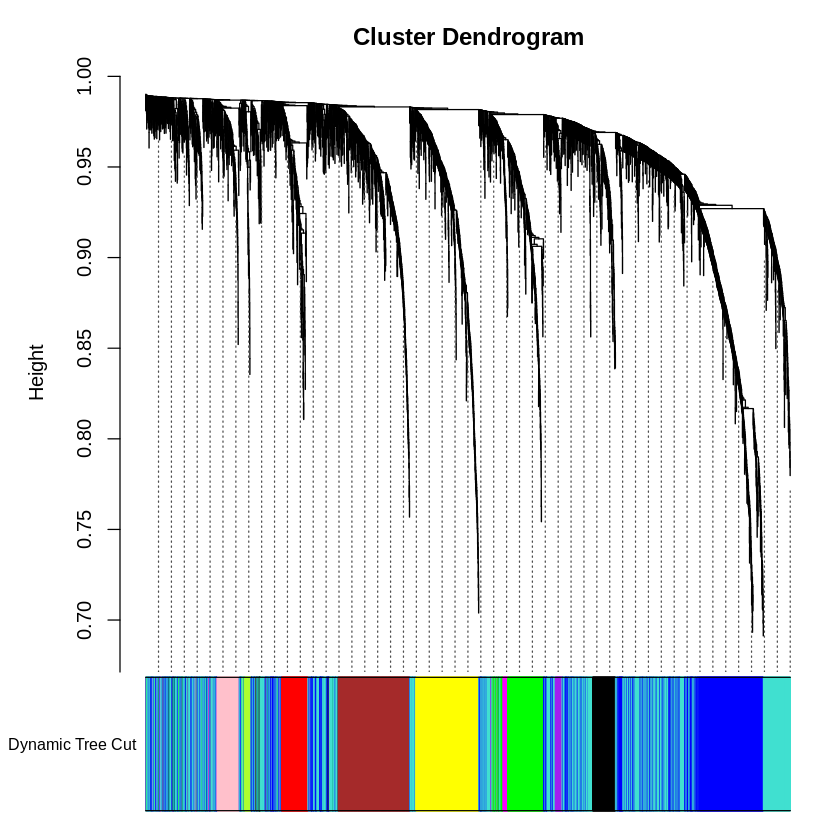

In [115]:
# Plot the dendrogram with module colors
plotDendroAndColors(geneTree, moduleColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

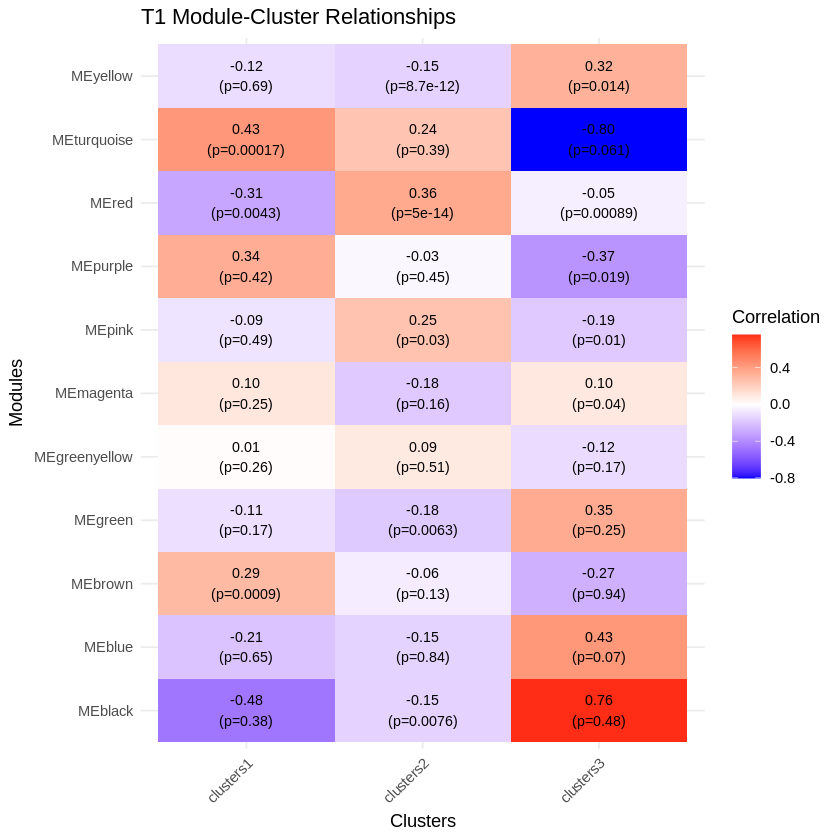

In [116]:
# Add cluster information to module calculations
clusters <- as.factor(new_data$cluster)

# Calculate module eigengenes
MEs <- moduleEigengenes(datExpr, colors = moduleColors)$eigengenes
MEs <- orderMEs(MEs)

# Create design matrix for cluster correlation
trait_matrix <- model.matrix(~ clusters - 1)

# Correlate module eigengenes with clusters
moduleTraitCor <- cor(MEs, trait_matrix, use = "p")
moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples = nrow(datExpr))

# Prepare tidy dataframe for plotting
moduleTrait_df <- as.data.frame(moduleTraitCor)
moduleTrait_df$Module <- rownames(moduleTrait_df)
moduleTrait_long <- moduleTrait_df %>%
  pivot_longer(-Module, names_to = "Cluster", values_to = "Correlation") %>%
  mutate(Pvalue = as.vector(moduleTraitPvalue))

# Plot heatmap with correlation and p-values
ggplot(moduleTrait_long, aes(x = Cluster, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f\n(p=%.2g)", Correlation, Pvalue)), size = 3) +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +
  theme_minimal() +
  labs(title = "T1 Module-Cluster Relationships",
       x = "Clusters",
       y = "Modules",
       fill = "Correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [85]:
df_raw_t2<- read.csv("/content/df_raw_T2.csv")

In [120]:
new_data <- df_raw_t2[, c("X", "cluster")]
filtered_data <- df_raw_t2 %>% select(-cluster)
transposed_data <- t(filtered_data)

# Setting the first row as column names
colnames(transposed_data) <- transposed_data[1,]
transposed_data <- transposed_data[-1,]

# Convert row names to a proper column if necessary
transposed_data <- as.data.frame(transposed_data)
transposed_data <- transposed_data %>% tibble::rownames_to_column(var = "geneID")
transposed_data[,-1] <- sapply(transposed_data[,-1], as.integer)

In [121]:
# Sum counts across all samples for each gene
gene_totals <- rowSums(transposed_data[, -1])

# Filter out genes with total counts less than 10
filtered_transposed_data <- transposed_data[gene_totals > 10, ]

# Prepare DESeq2 dataset using the filtered data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(filtered_transposed_data[, -1]),
                              colData = new_data,
                              design = ~ cluster)

# Proceed with DESeq2 normalization and analysis
dds <- estimateSizeFactors(dds)
dds <- estimateDispersionsGeneEst(dds)
dispersions(dds) <- mcols(dds)$dispGeneEst
dds <- nbinomWaldTest(dds)

# Extract normalized counts
normalized_counts <- counts(dds, normalized = TRUE)

# Add geneID back to normalized counts
rownames(normalized_counts) <- filtered_transposed_data$geneID

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



In [122]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("genefilter")
# filter out low variance genes
library(genefilter)
high_var_genes <- rowVars(normalized_counts) > quantile(rowVars(normalized_counts), 0.75)
filtered_data <- normalized_counts[high_var_genes, ]
datExpr <- t(filtered_data)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'genefilter'”
Old packages: 'cluster', 'shiny'



pickSoftThreshold: will use block size 4394.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4394 of 4394
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0551  1.15          0.968 722.000  7.01e+02 1180.0
2      2   0.2930 -1.29          0.887 189.000  1.70e+02  463.0
3      3   0.8420 -1.74          0.977  65.200  5.12e+01  241.0
4      4   0.9450 -1.94          0.990  27.600  1.79e+01  168.0
5      5   0.9660 -1.86          0.979  13.700  6.98e+00  130.0
6      6   0.9790 -1.74          0.987   7.770  2.98e+00  106.0
7      7   0.9750 -1.64          0.974   4.840  1.34e+00   89.4
8      8   0.9760 -1.57          0.973   3.250  6.30e-01   77.3
9      9   0.9840 -1.50          0.981   2.310  3.08e-01   68.0
10    10   0.9880 -1.44          0.985   1.710  1.57e-01   60.6
11    12   0.9760 -1.38          0.969   1.040  4.36e-02   49.7
12    14   0.9870 -1.33          0.984   0.698  1.37e-02   42.1
13    16   0.

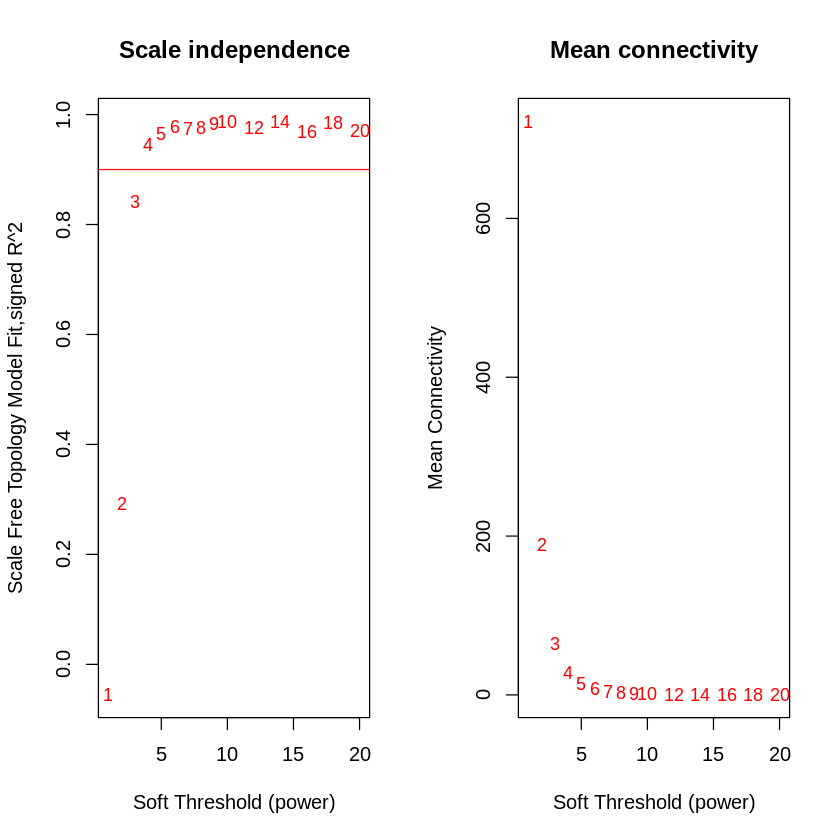

In [123]:
powers <- c(c(1:10), seq(from = 12, to = 20, by = 2))

# Network topology analysis
sft <- pickSoftThreshold(datExpr,
                         powerVector = powers,
                         verbose = 5,
                         networkType = "unsigned")

# Plot the results to help choose the soft threshold power
par(mfrow = c(1,2))
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.90,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [124]:
softPower <- min(powers[sft$fitIndices[, "SFT.R.sq"] >= 0.9])
# Build adjacency and TOM
adjacency <- adjacency(datExpr, power = softPower)
TOM <- TOMsimilarity(adjacency)
dissTOM <- 1 - TOM

# Hierarchical clustering of genes
geneTree <- hclust(as.dist(dissTOM), method = "average")

# Detect modules using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM,
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = 30)
moduleColors <- labels2colors(dynamicMods)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.994  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [125]:
gene_module_df <- data.frame(
  GeneID = colnames(datExpr),
  Module = moduleColors
)

write.csv(gene_module_df, file = "T2_gene_module_assignments.csv", row.names = FALSE)

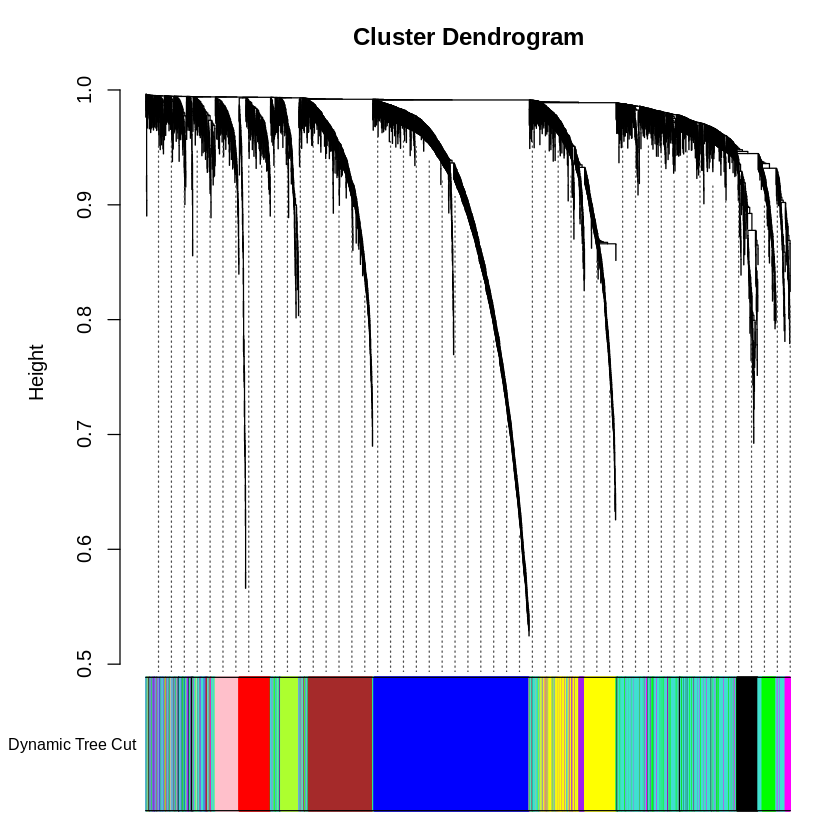

In [126]:
# Plot the dendrogram with module colors
plotDendroAndColors(geneTree, moduleColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

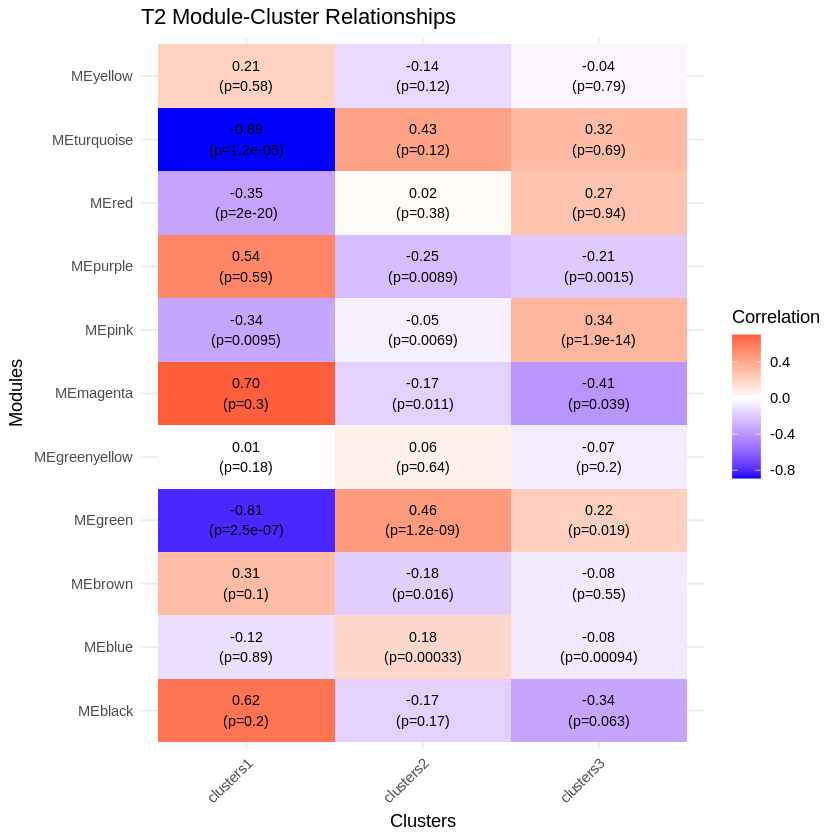

In [127]:
# Add cluster information to module calculations
clusters <- as.factor(new_data$cluster)

# Calculate module eigengenes
MEs <- moduleEigengenes(datExpr, colors = moduleColors)$eigengenes
MEs <- orderMEs(MEs)

# Create design matrix for cluster correlation
trait_matrix <- model.matrix(~ clusters - 1)

# Correlate module eigengenes with clusters
moduleTraitCor <- cor(MEs, trait_matrix, use = "p")
moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples = nrow(datExpr))

# Prepare tidy dataframe for plotting
moduleTrait_df <- as.data.frame(moduleTraitCor)
moduleTrait_df$Module <- rownames(moduleTrait_df)
moduleTrait_long <- moduleTrait_df %>%
  pivot_longer(-Module, names_to = "Cluster", values_to = "Correlation") %>%
  mutate(Pvalue = as.vector(moduleTraitPvalue))

# Plot heatmap with correlation and p-values
ggplot(moduleTrait_long, aes(x = Cluster, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f\n(p=%.2g)", Correlation, Pvalue)), size = 3) +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +
  theme_minimal() +
  labs(title = "T2 Module-Cluster Relationships",
       x = "Clusters",
       y = "Modules",
       fill = "Correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [128]:
df_raw_t3<- read.csv("/content/df_raw_T3.csv")

In [129]:
new_data <- df_raw_t3[, c("X", "cluster")]
filtered_data <- df_raw_t3 %>% select(-cluster)
transposed_data <- t(filtered_data)

# Setting the first row as column names
colnames(transposed_data) <- transposed_data[1,]
transposed_data <- transposed_data[-1,]

# Convert row names to a proper column if necessary
transposed_data <- as.data.frame(transposed_data)
transposed_data <- transposed_data %>% tibble::rownames_to_column(var = "geneID")
transposed_data[,-1] <- sapply(transposed_data[,-1], as.integer)
# Sum counts across all samples for each gene
gene_totals <- rowSums(transposed_data[, -1])

# Filter out genes with total counts less than 10
filtered_transposed_data <- transposed_data[gene_totals > 10, ]

# Prepare DESeq2 dataset using the filtered data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(filtered_transposed_data[, -1]),
                              colData = new_data,
                              design = ~ cluster)

# Proceed with DESeq2 normalization and analysis
dds <- estimateSizeFactors(dds)
dds <- estimateDispersionsGeneEst(dds)
dispersions(dds) <- mcols(dds)$dispGeneEst
dds <- nbinomWaldTest(dds)

# Extract normalized counts
normalized_counts <- counts(dds, normalized = TRUE)

# Add geneID back to normalized counts
rownames(normalized_counts) <- filtered_transposed_data$geneID
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("genefilter")
# filter out low variance genes
library(genefilter)
high_var_genes <- rowVars(normalized_counts) > quantile(rowVars(normalized_counts), 0.75)
filtered_data <- normalized_counts[high_var_genes, ]
datExpr <- t(filtered_data)

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'genefilter'”
Old packages: 'cluster', 'shiny'



pickSoftThreshold: will use block size 4436.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4436 of 4436
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1    0.173  2.250          0.925 711.0000  6.87e+02 1210.00
2      2    0.102 -0.958          0.883 179.0000  1.62e+02  480.00
3      3    0.711 -2.090          0.976  57.7000  4.79e+01  226.00
4      4    0.868 -2.300          0.997  22.3000  1.63e+01  124.00
5      5    0.875 -2.300          0.988   9.8600  6.09e+00   75.60
6      6    0.888 -2.160          0.987   4.8900  2.48e+00   49.10
7      7    0.867 -2.040          0.969   2.6600  1.07e+00   33.70
8      8    0.901 -1.820          0.969   1.5700  4.88e-01   24.00
9      9    0.931 -1.660          0.976   0.9910  2.32e-01   17.70
10    10    0.945 -1.560          0.981   0.6590  1.15e-01   13.90
11    12    0.899 -1.540          0.951   0.3320  3.07e-02    9.89
12    14    0.938 -1.410          0.973  

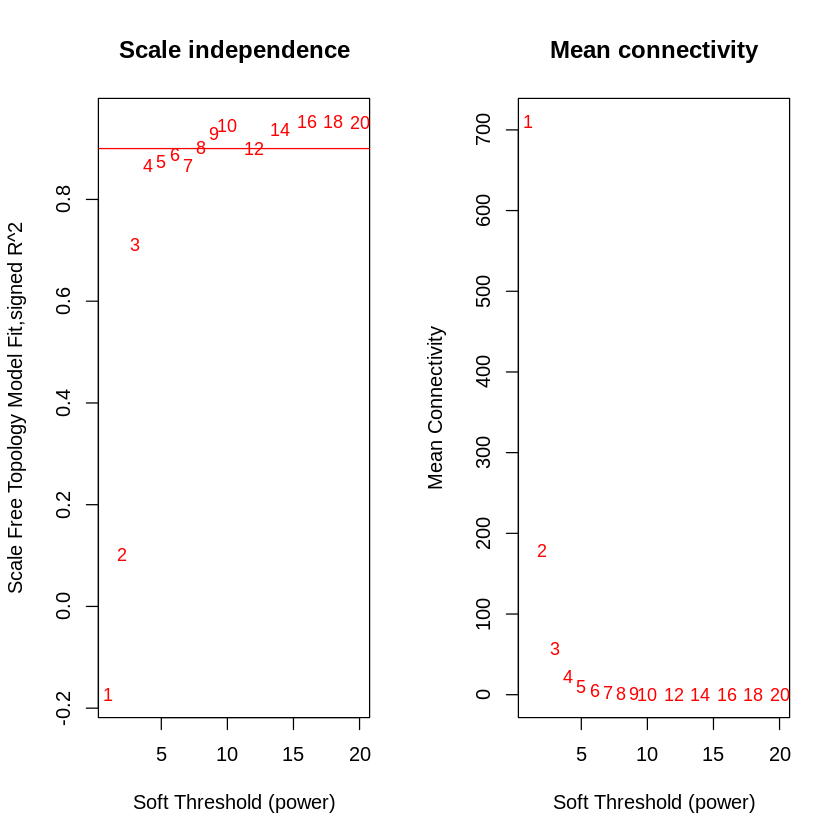

In [130]:
powers <- c(c(1:10), seq(from = 12, to = 20, by = 2))

# Network topology analysis
sft <- pickSoftThreshold(datExpr,
                         powerVector = powers,
                         verbose = 5,
                         networkType = "unsigned")

# Plot the results to help choose the soft threshold power
par(mfrow = c(1,2))
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.90,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [131]:
softPower <- min(powers[sft$fitIndices[, "SFT.R.sq"] >= 0.9])
# Build adjacency and TOM
adjacency <- adjacency(datExpr, power = softPower)
TOM <- TOMsimilarity(adjacency)
dissTOM <- 1 - TOM

# Hierarchical clustering of genes
geneTree <- hclust(as.dist(dissTOM), method = "average")

# Detect modules using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM,
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = 30)
moduleColors <- labels2colors(dynamicMods)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [132]:
gene_module_df <- data.frame(
  GeneID = colnames(datExpr),
  Module = moduleColors
)

write.csv(gene_module_df, file = "T3_gene_module_assignments.csv", row.names = FALSE)

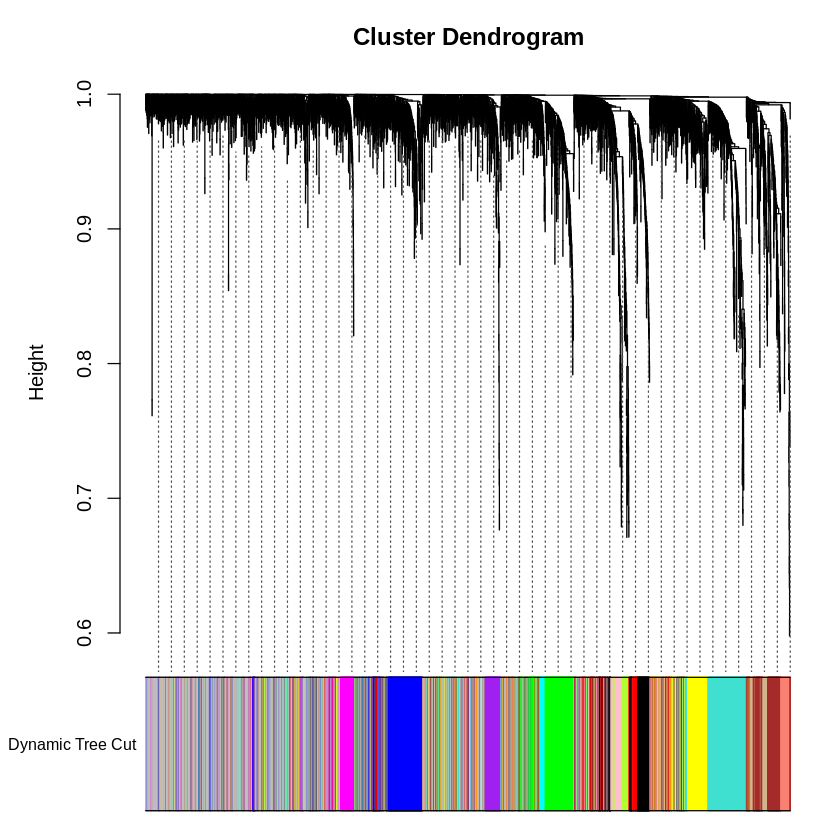

In [133]:
# Plot the dendrogram with module colors
plotDendroAndColors(geneTree, moduleColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

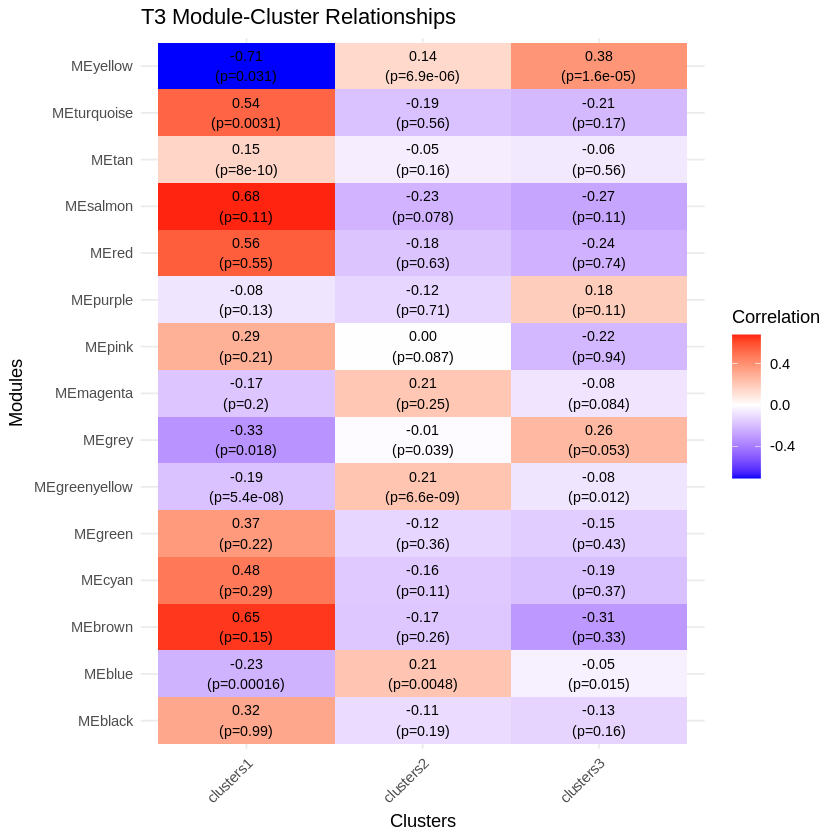

In [134]:
# Add cluster information to module calculations
clusters <- as.factor(new_data$cluster)

# Calculate module eigengenes
MEs <- moduleEigengenes(datExpr, colors = moduleColors)$eigengenes
MEs <- orderMEs(MEs)

# Create design matrix for cluster correlation
trait_matrix <- model.matrix(~ clusters - 1)

# Correlate module eigengenes with clusters
moduleTraitCor <- cor(MEs, trait_matrix, use = "p")
moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples = nrow(datExpr))

# Prepare tidy dataframe for plotting
moduleTrait_df <- as.data.frame(moduleTraitCor)
moduleTrait_df$Module <- rownames(moduleTrait_df)
moduleTrait_long <- moduleTrait_df %>%
  pivot_longer(-Module, names_to = "Cluster", values_to = "Correlation") %>%
  mutate(Pvalue = as.vector(moduleTraitPvalue))

# Plot heatmap with correlation and p-values
ggplot(moduleTrait_long, aes(x = Cluster, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f\n(p=%.2g)", Correlation, Pvalue)), size = 3) +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +
  theme_minimal() +
  labs(title = "T3 Module-Cluster Relationships",
       x = "Clusters",
       y = "Modules",
       fill = "Correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [98]:
df_raw_t4<- read.csv("/content/df_raw_T4.csv")

In [99]:
new_data <- df_raw_t4[, c("X", "cluster")]
filtered_data <- df_raw_t4 %>% select(-cluster)
transposed_data <- t(filtered_data)

# Setting the first row as column names
colnames(transposed_data) <- transposed_data[1,]
transposed_data <- transposed_data[-1,]

# Convert row names to a proper column if necessary
transposed_data <- as.data.frame(transposed_data)
transposed_data <- transposed_data %>% tibble::rownames_to_column(var = "geneID")
transposed_data[,-1] <- sapply(transposed_data[,-1], as.integer)
# Sum counts across all samples for each gene
gene_totals <- rowSums(transposed_data[, -1])

# Filter out genes with total counts less than 10
filtered_transposed_data <- transposed_data[gene_totals > 10, ]

# Prepare DESeq2 dataset using the filtered data
dds <- DESeqDataSetFromMatrix(countData = as.matrix(filtered_transposed_data[, -1]),
                              colData = new_data,
                              design = ~ cluster)

# Proceed with DESeq2 normalization and analysis
dds <- estimateSizeFactors(dds)
dds <- estimateDispersionsGeneEst(dds)
dispersions(dds) <- mcols(dds)$dispGeneEst
dds <- nbinomWaldTest(dds)

# Extract normalized counts
normalized_counts <- counts(dds, normalized = TRUE)

# Add geneID back to normalized counts
rownames(normalized_counts) <- filtered_transposed_data$geneID
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("genefilter")
# filter out low variance genes
library(genefilter)
high_var_genes <- rowVars(normalized_counts) > quantile(rowVars(normalized_counts), 0.75)
filtered_data <- normalized_counts[high_var_genes, ]
datExpr <- t(filtered_data)

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'genefilter'”
Old packages: 'cluster', 'shiny'



pickSoftThreshold: will use block size 4359.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4359 of 4359
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.336  2.680          0.780  731.00  6.69e+02 1260.0
2      2    0.128 -0.611          0.121  205.00  1.56e+02  608.0
3      3    0.939 -1.440          0.980   81.60  4.63e+01  419.0
4      4    0.935 -1.300          0.989   42.00  1.61e+01  331.0
5      5    0.956 -1.190          0.994   25.90  6.31e+00  279.0
6      6    0.968 -1.120          0.994   17.90  2.67e+00  242.0
7      7    0.975 -1.070          0.996   13.30  1.22e+00  215.0
8      8    0.978 -1.040          0.993   10.40  5.86e-01  193.0
9      9    0.982 -1.020          0.995    8.45  2.93e-01  176.0
10    10    0.977 -1.000          0.989    7.01  1.53e-01  161.0
11    12    0.983 -0.995          0.998    5.10  4.55e-02  139.0
12    14    0.980 -0.983          0.987    3.91  1.46e-02  122.0


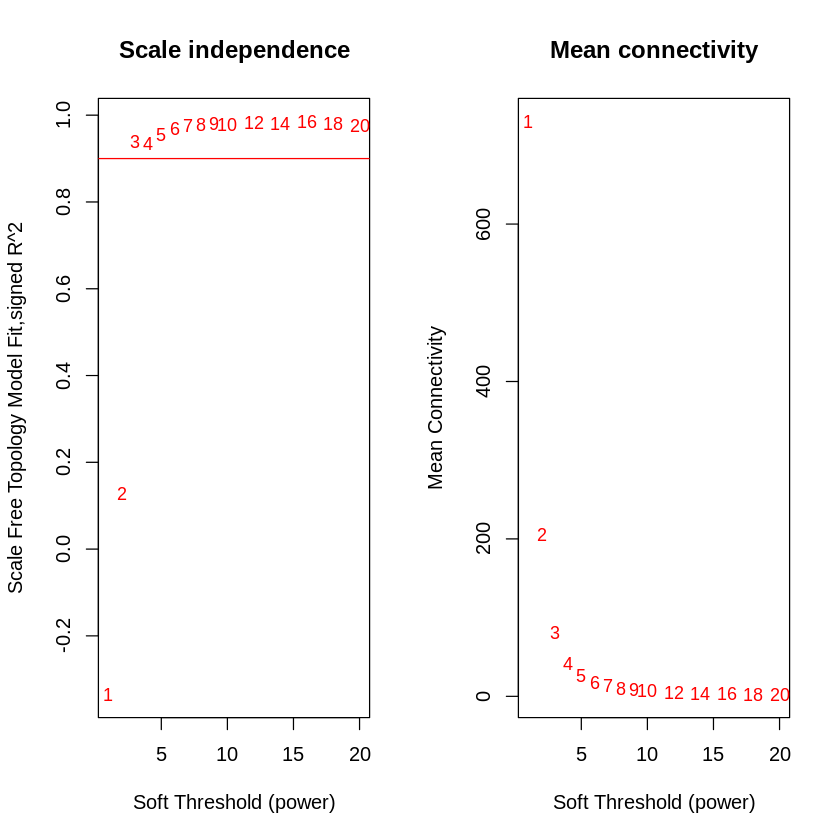

In [100]:
powers <- c(c(1:10), seq(from = 12, to = 20, by = 2))

# Network topology analysis
sft <- pickSoftThreshold(datExpr,
                         powerVector = powers,
                         verbose = 5,
                         networkType = "unsigned")

# Plot the results to help choose the soft threshold power
par(mfrow = c(1,2))
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.90,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [101]:
softPower <- min(powers[sft$fitIndices[, "SFT.R.sq"] >= 0.9])
# Build adjacency and TOM
adjacency <- adjacency(datExpr, power = softPower)
TOM <- TOMsimilarity(adjacency)
dissTOM <- 1 - TOM

# Hierarchical clustering of genes
geneTree <- hclust(as.dist(dissTOM), method = "average")

# Detect modules using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM,
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = 30)
moduleColors <- labels2colors(dynamicMods)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.984  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [103]:
gene_module_df <- data.frame(
  GeneID = colnames(datExpr),
  Module = moduleColors
)

write.csv(gene_module_df, file = "T4_gene_module_assignments.csv", row.names = FALSE)


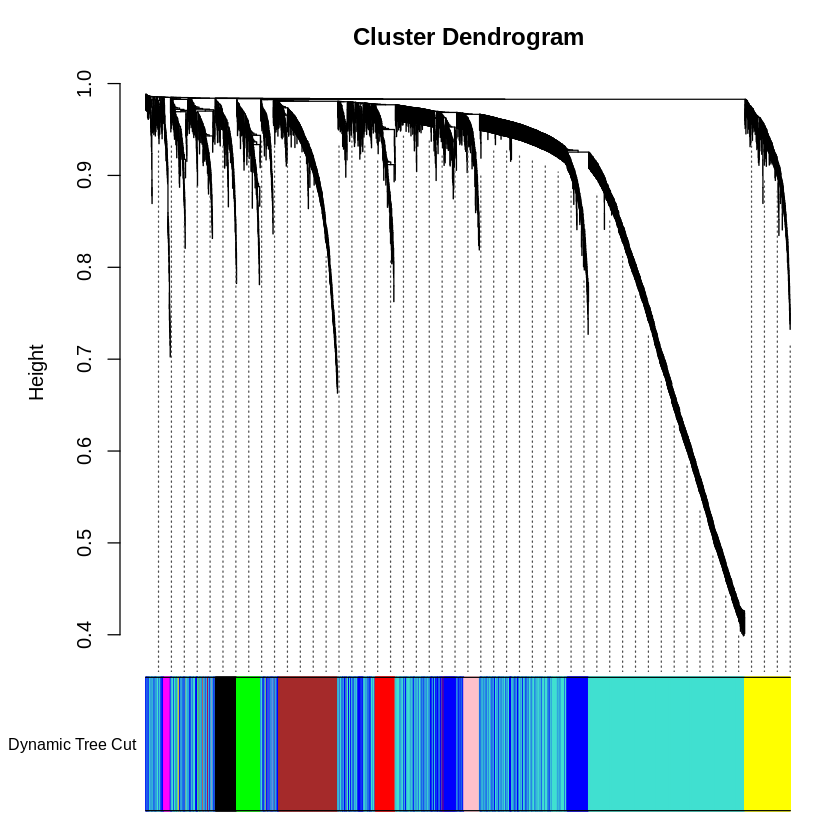

In [104]:
# Plot the dendrogram with module colors
plotDendroAndColors(geneTree, moduleColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

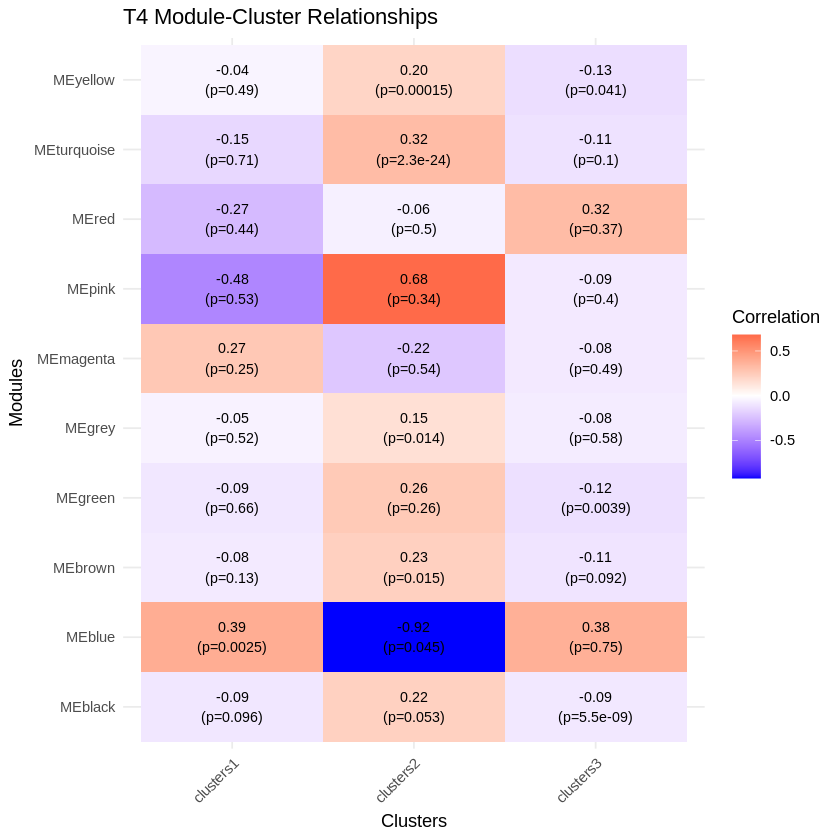

In [105]:
# Add cluster information to module calculations
clusters <- as.factor(new_data$cluster)

# Calculate module eigengenes
MEs <- moduleEigengenes(datExpr, colors = moduleColors)$eigengenes
MEs <- orderMEs(MEs)

# Create design matrix for cluster correlation
trait_matrix <- model.matrix(~ clusters - 1)

# Correlate module eigengenes with clusters
moduleTraitCor <- cor(MEs, trait_matrix, use = "p")
moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples = nrow(datExpr))

# Prepare tidy dataframe for plotting
moduleTrait_df <- as.data.frame(moduleTraitCor)
moduleTrait_df$Module <- rownames(moduleTrait_df)
moduleTrait_long <- moduleTrait_df %>%
  pivot_longer(-Module, names_to = "Cluster", values_to = "Correlation") %>%
  mutate(Pvalue = as.vector(moduleTraitPvalue))

# Plot heatmap with correlation and p-values
ggplot(moduleTrait_long, aes(x = Cluster, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f\n(p=%.2g)", Correlation, Pvalue)), size = 3) +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +
  theme_minimal() +
  labs(title = "T4 Module-Cluster Relationships",
       x = "Clusters",
       y = "Modules",
       fill = "Correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))